# MOD 4 Project

#### Name : Filiz Camuz
#### Track: Data Science SP
#### Coach: Eli

-------------------------------------------------

## Time Series Model for Real Estate Investment Company

This model is for suggesting the best 5 zipcodes to invest for a Real Estate Investment Company. Conditions are listed below. 

- Company would like to invest in Texas
- The range of the investment is not defined, it could be any amount
- Company would like to do investment for at least 3 years span. 




# Step 1: Load the Data 

In [2]:
import warnings
warnings.filterwarnings('ignore')
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
plt.style.use('ggplot')
warnings.filterwarnings("ignore") #ignore the warnings to avoid a lot of noise from running the procedure

In [3]:
df=pd.read_csv('zillow_data.csv')
df.head(2)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800


In [4]:
df.shape


(14723, 272)

In [5]:
df.isna().sum()

RegionID         0
RegionName       0
City             0
State            0
Metro         1043
              ... 
2017-12          0
2018-01          0
2018-02          0
2018-03          0
2018-04          0
Length: 272, dtype: int64

In [6]:
df.isna().sum().sum()

157934

In [7]:
df.dtypes

RegionID       int64
RegionName     int64
City          object
State         object
Metro         object
               ...  
2017-12        int64
2018-01        int64
2018-02        int64
2018-03        int64
2018-04        int64
Length: 272, dtype: object


# Step 2: Feature Engineering


### Dealing with Null values

In [8]:
df_full=df # keep the original dataframe as it is (df)
df_full.Metro.fillna(df_full.City, inplace=True) # fill missing metro with city iname
df_full=df_full.bfill(axis='columns') # use .bfill() method to fill missing price data, 
#.bfill() converted datatype to object so, it will be handled later
df_full.index=df_full.RegionName
df_full.drop('RegionName', axis=1, inplace=True)


### Filtering for Chosen Zipcodes 

In [152]:
def select_state_top10 (df, state ):
    df['increase'] =(df['2018-04'] - df['1996-04'])  #calculate price change and the percentage of the increase
    df['increase_rate'] = df['increase']/df['1996-04'] 
    df['criteria']= df['increase']*df['increase_rate']
    df_state=df[df['State']==state] #filter state
    df2 = df_state.iloc[:, 6:]  #select only the price data
    df2.sort_values(by= ['criteria'], ascending=False, inplace=True) #sort by rate and slice top 10
    df10 =  df2.iloc[:10, :].astype(int)  #convert datatype to int
    df2.sort_values(by= ['criteria'], ascending=False, inplace=True) #sort by increase and slice top 10
    df10_growth = df2.iloc[:10, :].astype(int) 
    return df10, df10_growth, df

In [ ]:
top10_rate, top10_growth, df_full_2= select_state_top10 (df_full, 'TX')
top10_rate.head(3)
df.head()

### Convert dataframe to time series 

In [154]:
def convert_to_ts (df):   
    ts=df.drop(['increase','increase_rate','criteria'], axis=1)  #drop columns other than price 
    ts=ts.T     # Transpose the dataframe
    ts.index=pd.to_datetime(ts.index)   #change index type to timestamp
    ts=ts.astype(int)  
    return ts

In [155]:
ts_top10_rate=convert_to_ts (top10_rate)
ts_top10_growth=convert_to_ts (top10_growth)

# DO NOT  TOUCH the CODE ABOVE!

# Step 3: EDA and Visualization

In [114]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)
plt.gcf().autofmt_xdate()
# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

<Figure size 432x288 with 0 Axes>

In [115]:
df_full_states=df_full_2.drop(['RegionID', 'City', 'CountyName','Metro','SizeRank'],axis=1)


In [116]:
df_full_states

,State,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,...,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,increase,increase_rate
RegionName,,,,,,,,,,,,,,,,,,,,,
60657,IL,334200,335400,336500,337600,338500,339500,340400,341300,342600,...,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600,696400,2.08378
75070,TX,235700,236900,236700,235400,233300,230600,227300,223400,219600,...,312500,314100,315000,316600,318100,319600,321100,321800,86100,0.365295
77494,TX,210400,212200,212200,210700,208300,205500,202500,199800,198300,...,320200,320400,320800,321200,321200,323000,326900,329900,119500,0.567966
60614,IL,498100,500900,503100,504600,505500,505700,505300,504200,503600,...,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000,808900,1.62397
79936,TX,77300,77300,77300,77300,77400,77500,77600,77700,77700,...,120000,120300,120300,120300,120300,120500,121000,121500,44200,0.571798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1338,MA,94600,94300,94000,93700,93400,93200,93000,92900,92700,...,218600,218500,218100,216400,213100,209800,209200,209300,114700,1.21247
3293,NH,92700,92500,92400,92200,92100,91900,91700,91300,90900,...,212200,215200,214300,213100,213700,218300,222700,225800,133100,1.43581
40404,KY,57100,57300,57500,57700,58000,58200,58400,58700,59100,...,124600,126700,128800,130600,131700,132500,133000,133400,76300,1.33625


## Top 10 states in US for average price increase 

Text(0, 0.5, 'Increase Rate')

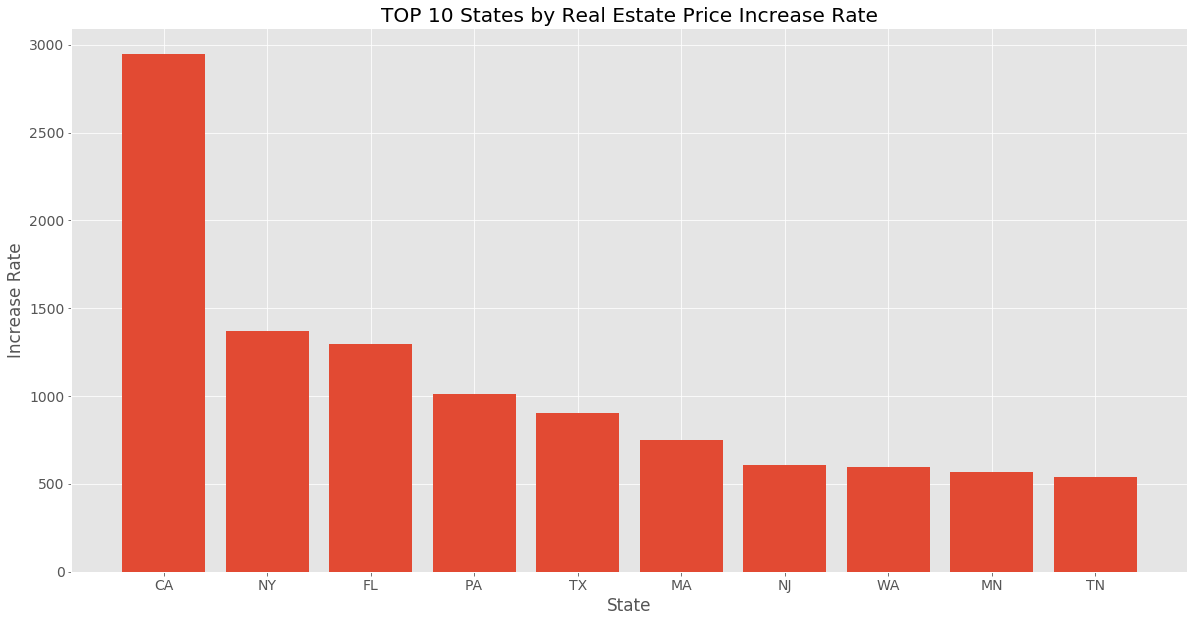

In [118]:
plt.figure(figsize = (20,10))
plt.bar(top10_state.index, top10_state['increase_rate'] )
plt.title('TOP 10 States by Real Estate Price Increase Rate')
plt.xlabel('State')
plt.ylabel('Increase Rate')

## Reasons behind California significant lead

In [137]:
#I would like to see how why California is so different than the others.
df_full_CA= df_full_2[df_full_2['State']=='CA']
df_full_CA = df_full_CA.drop(['RegionID', 'CountyName','Metro','SizeRank','State'],axis=1)
df_full_CA['rate_criteria']=df_full_CA['increase']*df_full_CA['increase_rate']
ca_city=df_full_CA.set_index('City').astype(float).groupby('City').mean().sort_values('rate_criteria')

In [138]:
ca_city

,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,...,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,increase,increase_rate,rate_criteria
City,,,,,,,,,,,,,,,,,,,,,
Clearlake Oaks,1.823000e+05,1.823000e+05,182300.0,1.823000e+05,1.823000e+05,1.823000e+05,1.823000e+05,1.823000e+05,1.823000e+05,1.823000e+05,...,1.827000e+05,1.843000e+05,1.841000e+05,1.836000e+05,1.846000e+05,1.855000e+05,1.860000e+05,3.700000e+03,0.020296,7.509600e+01
Portola,1.420000e+05,1.407000e+05,139300.0,1.379000e+05,1.366000e+05,1.355000e+05,1.344000e+05,1.330000e+05,1.319000e+05,1.316000e+05,...,1.368000e+05,1.395000e+05,1.433000e+05,1.451000e+05,1.453000e+05,1.452000e+05,1.460000e+05,4.000000e+03,0.028169,1.126761e+02
Hidden Valley Lake,2.900000e+05,2.900000e+05,290000.0,2.900000e+05,2.900000e+05,2.900000e+05,2.900000e+05,2.900000e+05,2.900000e+05,2.900000e+05,...,2.900000e+05,2.889000e+05,2.899000e+05,2.910000e+05,2.931000e+05,2.970000e+05,3.003000e+05,1.030000e+04,0.035517,3.658276e+02
Middletown,2.260000e+05,2.260000e+05,226000.0,2.260000e+05,2.260000e+05,2.260000e+05,2.260000e+05,2.260000e+05,2.260000e+05,2.260000e+05,...,1.933000e+05,1.954000e+05,1.994000e+05,2.013000e+05,2.030000e+05,2.074000e+05,2.130000e+05,-1.300000e+04,-0.057522,7.477876e+02
Kelseyville,2.508000e+05,2.508000e+05,250800.0,2.508000e+05,2.508000e+05,2.508000e+05,2.508000e+05,2.508000e+05,2.508000e+05,2.508000e+05,...,2.612000e+05,2.623000e+05,2.634000e+05,2.638000e+05,2.646000e+05,2.668000e+05,2.693000e+05,1.850000e+04,0.073764,1.364633e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
West Hollywood,5.336000e+05,5.359000e+05,538200.0,5.405000e+05,5.430000e+05,5.458000e+05,5.490000e+05,5.525000e+05,5.571000e+05,5.626000e+05,...,3.043100e+06,3.073000e+06,3.087500e+06,3.103000e+06,3.121000e+06,3.143300e+06,3.155900e+06,2.622300e+06,4.914355,1.288691e+07
Beverly Hills,7.097000e+05,7.123333e+05,715000.0,7.176333e+05,7.204667e+05,7.235333e+05,7.273333e+05,7.316000e+05,7.371333e+05,7.437333e+05,...,3.670100e+06,3.711967e+06,3.758667e+06,3.801433e+06,3.840667e+06,3.880300e+06,3.899300e+06,3.189600e+06,4.481178,1.452882e+07
Los Altos,7.039000e+05,7.061500e+05,708650.0,7.114500e+05,7.146000e+05,7.182500e+05,7.228500e+05,7.283000e+05,7.355000e+05,7.442500e+05,...,3.593250e+06,3.675950e+06,3.742050e+06,3.790200e+06,3.847550e+06,3.922350e+06,3.967600e+06,3.263700e+06,4.657659,1.515055e+07


California is a large state. While there is a significant increase in some cities, there is also decrease in the average real estate price in other cities. Lets look at the best 5 cities price change over time. 

In [142]:
plot_ca=(ca_city.tail(5).drop(['increase', 'increase_rate','rate_criteria'], axis=1))
plot_ca

,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
City,,,,,,,,,,,,,,,,,,,,,
West Hollywood,5.336000e+05,5.359000e+05,538200.0,5.405000e+05,5.430000e+05,5.458000e+05,5.490000e+05,5.525000e+05,5.571000e+05,5.626000e+05,...,2.936800e+06,2.959000e+06,2.998700e+06,3.043100e+06,3.073000e+06,3.087500e+06,3.103000e+06,3.121000e+06,3.143300e+06,3.155900e+06
Beverly Hills,7.097000e+05,7.123333e+05,715000.0,7.176333e+05,7.204667e+05,7.235333e+05,7.273333e+05,7.316000e+05,7.371333e+05,7.437333e+05,...,3.554833e+06,3.591567e+06,3.630600e+06,3.670100e+06,3.711967e+06,3.758667e+06,3.801433e+06,3.840667e+06,3.880300e+06,3.899300e+06
Los Altos,7.039000e+05,7.061500e+05,708650.0,7.114500e+05,7.146000e+05,7.182500e+05,7.228500e+05,7.283000e+05,7.355000e+05,7.442500e+05,...,3.389500e+06,3.447800e+06,3.516000e+06,3.593250e+06,3.675950e+06,3.742050e+06,3.790200e+06,3.847550e+06,3.922350e+06,3.967600e+06
Palo Alto,5.081333e+05,5.098333e+05,511900.0,5.143667e+05,5.172333e+05,5.206000e+05,5.246000e+05,5.292667e+05,5.349333e+05,5.416333e+05,...,3.135433e+06,3.176967e+06,3.238067e+06,3.312267e+06,3.380133e+06,3.426500e+06,3.461567e+06,3.512100e+06,3.575667e+06,3.612467e+06
Atherton,1.179200e+06,1.184300e+06,1189700.0,1.195400e+06,1.201200e+06,1.207300e+06,1.214100e+06,1.221200e+06,1.230900e+06,1.242600e+06,...,6.138300e+06,6.197800e+06,6.250200e+06,6.315400e+06,6.429100e+06,6.581800e+06,6.705000e+06,6.764600e+06,6.788400e+06,6.796500e+06


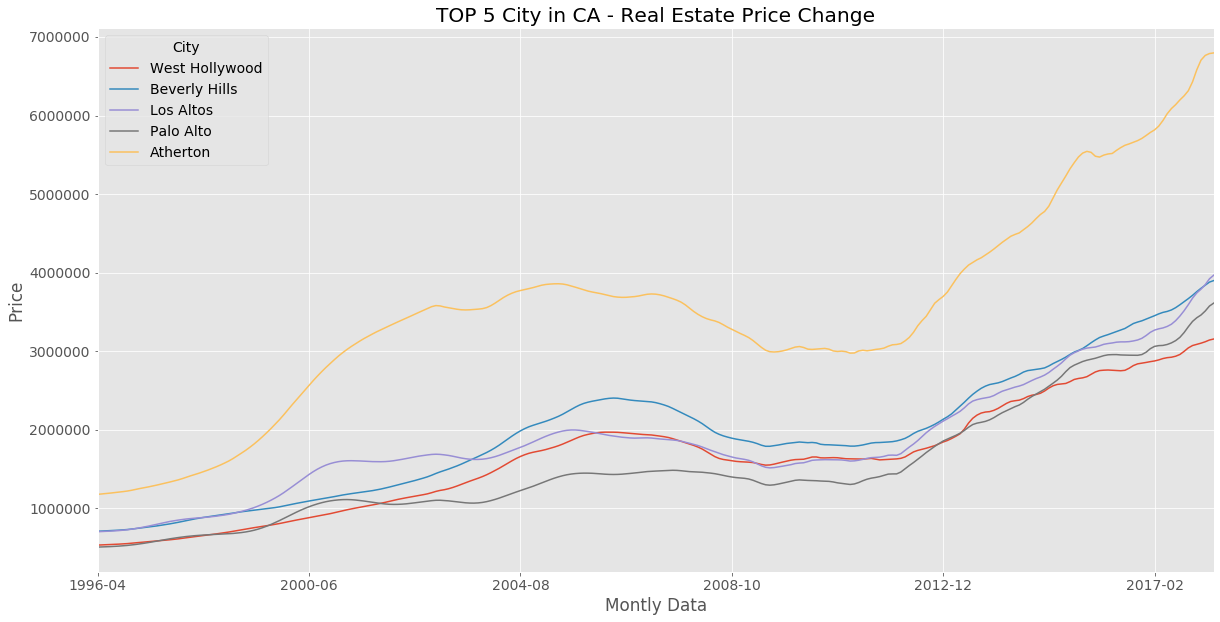

In [158]:
(plot_ca.T).plot(figsize = (20,10), subplots=False, legend=True)
plt.title('TOP 5 City in CA - Real Estate Price Change')
plt.xlabel('Montly Data')
plt.ylabel('Price')
plt.show()

Those five cities along with surrounding cities have been exceptionally well worthed investmen area in CA. There are two main reason for the high increase we observe here. One is most of the high technology companies clustered in the area called Silicon Valley. 3 of the top 5 cities in Silicon Valley and the other reason is most likely Hollywood. Beverly Hills and West Hollywood are where most of the celebrities purchase extremely  expensive real estates.

In [84]:
plot_ca['2012-01']

City
Hermosa Beach    9.880000e+05
Sunnyvale        6.779667e+05
Stinson Beach    1.146400e+06
Mountain View    9.036667e+05
Palo Alto        1.439733e+06
Name: 2012-01, dtype: float64

Real estates in top 5 cities in Silicon Valley used to range averagely 1M -1.5M in 2012. It now 2M-3.6M. I would like to run similar analysis for Texas since the company would like to invest on this state.


## Top 5 Cities in Texas

In [130]:
df_full_TX= df_full_2[df_full_2['State']=='TX']
df_full_TX = df_full_TX.drop(['RegionID', 'CountyName','Metro','SizeRank','State'],axis=1)
df_full_TX['rate_criteria']=df_full_TX['increase']*df_full_TX['increase_rate']
TX_city=df_full_TX.set_index('City').astype(float).groupby('City').agg(np.mean).sort_values('rate_criteria')

In [132]:
TX_city.tail(5)

,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,...,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,increase,increase_rate,rate_criteria
City,,,,,,,,,,,,,,,,,,,,,
Luling,25000.000000,25200.000000,25500.000000,25800.000000,26100.000000,26400.000000,26800.000000,27100.000000,27500.000000,27900.000000,...,1.023000e+05,1.024000e+05,1.030000e+05,1.033000e+05,1.041000e+05,1.059000e+05,1.070000e+05,82000.000000,3.280000,268960.000000
Paige,54300.000000,55000.000000,55700.000000,56300.000000,57000.000000,57700.000000,58400.000000,59100.000000,59800.000000,60500.000000,...,1.728000e+05,1.735000e+05,1.751000e+05,1.758000e+05,1.773000e+05,1.814000e+05,1.857000e+05,131400.000000,2.419890,317973.480663
Austin,217871.052632,217673.684211,217610.526316,217657.894737,217792.105263,217992.105263,218194.736842,218452.631579,218655.263158,218773.684211,...,3.904026e+05,3.922605e+05,3.938789e+05,3.953237e+05,3.977868e+05,4.017658e+05,4.044974e+05,186626.315789,1.312372,337641.069417
Martindale,68600.000000,69000.000000,69400.000000,69900.000000,70300.000000,70800.000000,71400.000000,71900.000000,72600.000000,73300.000000,...,2.152000e+05,2.165000e+05,2.171000e+05,2.177000e+05,2.195000e+05,2.216000e+05,2.223000e+05,153700.000000,2.240525,344368.658892
University Park,640100.000000,637000.000000,634200.000000,631800.000000,630200.000000,629300.000000,629300.000000,630200.000000,631600.000000,633600.000000,...,1.246400e+06,1.245700e+06,1.245900e+06,1.250200e+06,1.258300e+06,1.265800e+06,1.268600e+06,628500.000000,0.981878,617110.217154


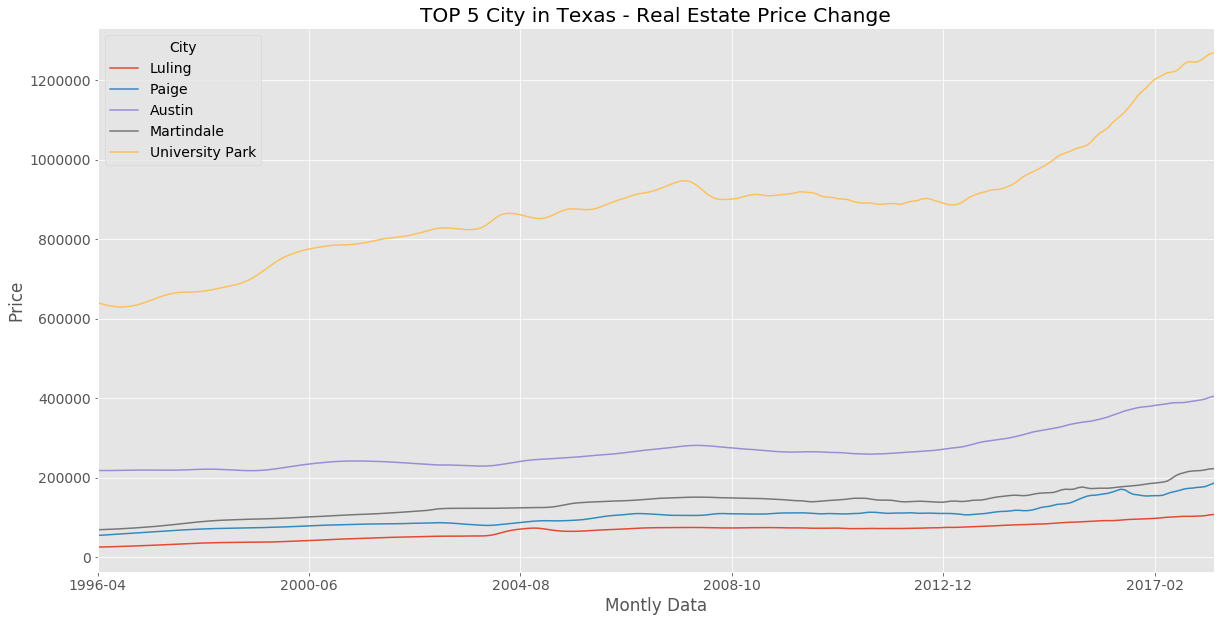

In [159]:
plot_tx=(TX_city.tail(5).drop(['increase', 'increase_rate', 'rate_criteria'], axis=1))
(plot_tx.T).plot(figsize = (20,10), subplots=False, legend=True)
plt.title('TOP 5 City in Texas - Real Estate Price Change')
plt.xlabel('Montly Data')
plt.ylabel('Price')
plt.show()

University Park is a small city where University of North Texas is located. Probably because of that surrounding area estates has been very expensive and the price keep increasing.
Austin started increasing trend since 2012 and seem taking off. 
Now lets see what is the best 10 zipcodes in Texas area.


## Top 10 zipcodes in Texas

In [156]:
ts_top10_rate

RegionName,78702,78722,78751,78703,78721,78723,75205,78752,78757,78705
1996-04-01,55600,76200,115900,355200,69200,97600,640100,87200,150300,197500
1996-05-01,56700,76400,116900,351300,68800,99000,637000,87000,150900,199300
1996-06-01,57900,76500,118000,347800,68400,100300,634200,86800,152100,201000
1996-07-01,59300,76700,119100,344900,68100,101400,631800,86700,153600,202700
1996-08-01,60800,77000,120200,342400,67800,101900,630200,86500,155300,204300
...,...,...,...,...,...,...,...,...,...,...
2017-12-01,405200,403300,434500,876700,293000,352500,1245900,299300,420600,483200
2018-01-01,410100,405200,436100,875900,296300,355800,1250200,300400,424000,484300
2018-02-01,413800,408400,437600,880100,297800,358700,1258300,301400,426300,489100
2018-03-01,417300,413900,441200,884600,297200,361900,1265800,302300,427900,501200


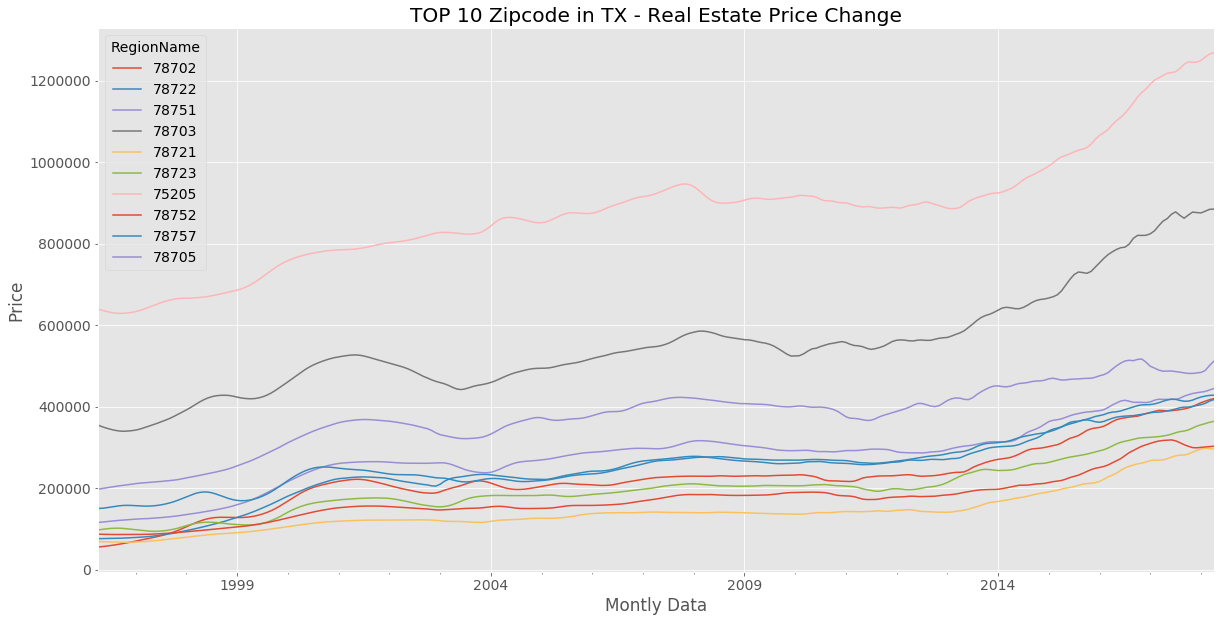

In [168]:
ts_top10_rate.plot(figsize = (20,10), subplots=False, legend=True)
plt.title('TOP 10 Zipcode in TX - Real Estate Price Change')
plt.xlabel('Montly Data')
plt.ylabel('Price')
plt.show()

## Preferable investment amount per purchase

In [175]:
print("Average investment belove 500K ", round(top10_rate[top10_rate['2018-04']<500000]['2018-04'].mean(),0))
print("Growth rate for the past 12 years", round(top10_rate[top10_rate['2018-04']<500000]['increase_rate'].mean(),1))

Average investment belove 500K  381957.0
Growth rate for the past 12 years 2.9


In [176]:
print("Average investment belove 500K ", round(top10_rate[top10_rate['2018-04']>500000]['2018-04'].mean(),0))
print("Growth rate for the past 12 years", round(top10_rate[top10_rate['2018-04']>500000]['increase_rate'].mean(),1))

Average investment belove 500K  888500.0
Growth rate for the past 12 years 0.7


In [379]:
#  Cut data from 2012 
#  calculate variance for risk 
 
rolmean = df_state_top10.rolling(window = 4).mean()
rolstd = df_state_top10.rolling(window = 4).std()
"""
#df_state_top10.plot(figsize = (20,10), subplots=False, legend=True)

fig = plt.figure(figsize=(11,7))
orig = plt.plot(df_state_top10, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='green', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)"""


"\n#df_state_top10.plot(figsize = (20,10), subplots=False, legend=True)\n\nfig = plt.figure(figsize=(11,7))\norig = plt.plot(df_state_top10, color='blue',label='Original')\nmean = plt.plot(rolmean, color='red', label='Rolling Mean')\nstd = plt.plot(rolstd, color='green', label='Rolling Std')\nplt.legend(loc='best')\nplt.title('Rolling Mean & Standard Deviation')\nplt.show(block=False)"

# DO NOT CHANGE DATAFRAME NAME AFTER THIS POINT , "ts"  is the name

### Convert data to timeseries

In [341]:
ts=ts_top10_rate
ts

RegionName,78702,78722,78648,78721,78751,78723,78752,78659,78655,78957
1996-04-01,55600,76200,25000,69200,115900,97600,87200,54300,68600,48500
1996-05-01,56700,76400,25200,68800,116900,99000,87000,55000,69000,48600
1996-06-01,57900,76500,25500,68400,118000,100300,86800,55700,69400,48800
1996-07-01,59300,76700,25800,68100,119100,101400,86700,56300,69900,48900
1996-08-01,60800,77000,26100,67800,120200,101900,86500,57000,70300,49100
...,...,...,...,...,...,...,...,...,...,...
2017-12-01,405200,403300,103000,293000,434500,352500,299300,175100,217100,145400
2018-01-01,410100,405200,103300,296300,436100,355800,300400,175800,217700,146300
2018-02-01,413800,408400,104100,297800,437600,358700,301400,177300,219500,148400
2018-03-01,417300,413900,105900,297200,441200,361900,302300,181400,221600,152400


# Step 4. Dickey Fuller Test for Stationarity Check

In [342]:

for i in ts.columns:
    X = ts[i]
    result = adfuller(X)
    print(i)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

78702
ADF Statistic: -0.361987
p-value: 0.916255
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
78722
ADF Statistic: -0.866868
p-value: 0.798688
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
78648
ADF Statistic: -0.026567
p-value: 0.956279
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
78721
ADF Statistic: -0.271275
p-value: 0.929475
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
78751
ADF Statistic: -1.194357
p-value: 0.676018
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
78723
ADF Statistic: 0.575811
p-value: 0.987004
Critical Values:
	1%: -3.456
	5%: -2.873
	10%: -2.573
78752
ADF Statistic: -0.104332
p-value: 0.949005
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
78659
ADF Statistic: 1.516156
p-value: 0.997583
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
78655
ADF Statistic: 0.530278
p-value: 0.985765
Critical Values:
	1%: -3.456
	5%: -2.873
	10%: -2.573
78957
ADF Statistic: 1.480630
p-value: 0.997451
Critical Values:
	1%: -3.457

None of the columns in the time series data is stationary. So I will use ARIMA Model since it can handle non-stationary data. I will do grid search to figure out best combinations for the necessary parameters. 

In [523]:
#small data for testing purposes only before passing the entire ts. 
df_2=ts.iloc[:,:2]
#df_2= df_2.iloc[:3, :]
df_2
df_1=ts.iloc[:,:1]
#df_1

# Step 5: ARIMA Modelling

## Functions for Modelling and Analysing

In [344]:
def iterations ():
    p = range(0,4)
    d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))  # Generate all different combinations of p, d, q and s triplets
    pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    return pdq, pdqs 


def grid_search (df, pdq, pdqs):
    # Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(df,
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                output = mod.fit()
                ans.append([comb, combs, output.aic])
                #print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
            except:
                continue

    # Find the parameters with minimal AIC value.
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
    ans_df.loc[ans_df['aic'].idxmin()]
    # Asign the best combinations to new lists
    pdq_new=ans_df.loc[ans_df['aic'].idxmin()].pdq
    pdqs_new=ans_df.loc[ans_df['aic'].idxmin()].pdqs
    print('Best ARIMA combination {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
    return  (pdq_new, pdqs_new)


def arima (df, pdq_new, pdqs_new ):

    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df,
                                    order=pdq_new,
                                    seasonal_order=pdqs_new,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

    output = ARIMA_MODEL.fit()
    #print(output.summary().tables[1])
    return output

def forecasting (model, steps):
    # Get forecast any steps ahead in future
    prediction = model.get_forecast(steps=steps)
    # Get confidence intervals of forecasts
    pred_conf = prediction.conf_int()
    return prediction , pred_conf


def model_tables (model):
    print(model.summary().tables[0])
    print(model.summary().tables[1])
    print(model.summary().tables[2])
    #print(model.summary())
    
def plot_diog(model):
    # Use plot_diagnostics with results calculated above.
    model.plot_diagnostics(figsize=(12, 8))
    
    

def prediction_plot(zipcode, model):
    prediction = model.get_forecast(60)
    pred_conf = prediction.conf_int()
    plt.figure(figsize=(18,8))
    plt.plot(zipcode, label='Observed Values')
    prediction.predicted_mean.plot(label='Forecast')
    plt.fill_between(pred_conf.index, pred_conf.iloc[:, 0], pred_conf.iloc[:, 1], color='grey')
    plt.title('{}'.format(zipcode.name))
    plt.ylabel('Average Real Estate Values')
    plt.xlabel('Dates')
    plt.legend();
    plt.show()
    
    
def predict (df):
    data = pd.DataFrame( columns = ['Zipcode' , 'Investment',  'forecast_3_years' , 'rate_3','3_year_min', '3_year_max',  
                                    'forecast_5_years' ,'rate_5', '5_year_min', '5_year_max', 'pdq', 'pdqs'])
    combs = []
    for i in df.columns:
        #pdq, pdqs =iterations()
        pdq_new,pdqs_new = (3,1,1), (3,1,1,12)
        #pdq_new, pdqs_new= grid_search (df[i], pdq, pdqs)
        output=arima(df[i], pdq_new, pdqs_new)
        # Get forecast any steps ahead in future
        prediction = output.get_forecast(steps=60)
        # Get confidence intervals of forecasts
        pred_conf = prediction.conf_int()
        #Get average predicted value 
        pred_conf['mean']=prediction.predicted_mean
        #Calculate increase rate for 3 and 5 years 
        increase_rate_3_years = round((pred_conf.iloc[35][2]- df[i][-1])/df[i][-1],2)
        increase_rate_5_years = round((pred_conf.iloc[59][2]- df[i][-1])/df[i][-1],2)
        # Store 36th and 60th month data points ( 3rd and 5th year)
        data=data.append(pd.Series([i,df[i][-1], round(pred_conf.iloc[35][2], 0),increase_rate_3_years, 
                               round(pred_conf.iloc[35][0],0), round(pred_conf.iloc[35][1],0), 
                             round(pred_conf.iloc[59][2],0) ,increase_rate_5_years, 
                               round(pred_conf.iloc[59][0],0) , round(pred_conf.iloc[59][1],0), pdq_new, pdqs_new], 
                                   index=data.columns ), ignore_index=True)
        #Store parameter combinations in a seperate list 
        combs.append([i, pdq_new, pdqs_new])
        
    return data, combs


def report_plot (zipcodes, combs, df, df_full):
       
        for i in zipcodes :
            for k in range(len(combs)):
                if combs[k][0]==i:
                    pdq_new=combs[k][1]
                    pdqs_new = combs[k][2]
            
            output=arima(df[i], pdq_new, pdqs_new)
            prediction , pred_conf= forecasting (output, 60)
            pred_conf['mean']=prediction.predicted_mean
            #Calculate increase rate in 3 - 5 years
            
            increase_rate_3_years = round((pred_conf.iloc[35][2]- df[i][-1])/df[i][-1],2)
            increase_rate_5_years = round((pred_conf.iloc[59][2]- df[i][-1])/df[i][-1],2)
            
            
            
            #Plot the forecasted data along with the real data
            prediction_plot(df[i], output)
            
            # Get city and the state for the zipcodes
            city=(df_full[df_full['RegionName']==i].City).to_string(index=False)
            state = df_full[df_full['RegionName']==i].State.to_string(index=False)

            print("Zipcode :" , i)
            print("City : {}".format(city))
            print("State :", state)

            print("Investment($) :", df[i][-1] )
            print("********")
            print("Predicted price in 3 years :",round(pred_conf.iloc[35][2],0) )
            print("Total Increase in 3 years :", pred_conf.iloc[35][2]- df[i][-1]) 
            print('Increase rate in 3 years (%) :', increase_rate_3_years)
            print("Possible range :", round(pred_conf.iloc[35][0],0)," - ",round(pred_conf.iloc[35][1],0) )
            print("********")
            print("Predicted price in 5 years :", round(pred_conf.iloc[59][2],0))
            print("Total Increase in 5 years :", pred_conf.iloc[59][2]- df[i][-1]) 
            print('Increase rate in 5 years (%) :', increase_rate_5_years)
            print("Possible range :", round(pred_conf.iloc[59][0],0)," - ", round(pred_conf.iloc[59][1],0) )
            print("-----------------------------------------------------------------------------")
        
            plot_diog(output)
        
        return 

### Modelling and Forecasting

In [345]:
pred_data, combs = predict(ts)

In [346]:
pred_data

,Zipcode,Investment,forecast_3_years,rate_3,3_year_min,3_year_max,forecast_5_years,rate_5,5_year_min,5_year_max,pdq,pdqs
0,78702,419800,465739.0,0.11,378902.0,552577.0,500701.0,0.19,376497.0,624906.0,"(3, 1, 1)","(3, 1, 1, 12)"
1,78722,417500,463557.0,0.11,386359.0,540756.0,493872.0,0.18,382721.0,605022.0,"(3, 1, 1)","(3, 1, 1, 12)"
2,78648,107000,117902.0,0.10,100801.0,135003.0,125152.0,0.17,102218.0,148085.0,"(3, 1, 1)","(3, 1, 1, 12)"
3,78721,296100,315650.0,0.07,255036.0,376264.0,332669.0,0.12,243837.0,421502.0,"(3, 1, 1)","(3, 1, 1, 12)"
4,78751,444500,488822.0,0.10,402476.0,575168.0,518393.0,0.17,396139.0,640647.0,"(3, 1, 1)","(3, 1, 1, 12)"
5,78723,364200,399504.0,0.10,337874.0,461134.0,424819.0,0.17,338066.0,511572.0,"(3, 1, 1)","(3, 1, 1, 12)"
6,78752,303100,344202.0,0.14,277373.0,411031.0,365730.0,0.21,270887.0,460573.0,"(3, 1, 1)","(3, 1, 1, 12)"
7,78659,185700,207203.0,0.12,172154.0,242253.0,220083.0,0.19,173492.0,266674.0,"(3, 1, 1)","(3, 1, 1, 12)"
8,78655,222300,263136.0,0.18,221084.0,305189.0,302750.0,0.36,232197.0,373303.0,"(3, 1, 1)","(3, 1, 1, 12)"
9,78957,155100,170069.0,0.10,147454.0,192684.0,180651.0,0.16,150004.0,211297.0,"(3, 1, 1)","(3, 1, 1, 12)"


### Filtering TOP 5 Zipcode from Forecasted Data

I added two columns to dataframe for the price increase within 3 years and 5 years. I sorted the data based on the percentage of price increase in the next 3 and 5 years.

In [347]:
pred_data['risk_range_3']=(pred_data['3_year_max']-pred_data['forecast_3_years'])/pred_data['forecast_3_years']
pred_data['risk_range_5']=(pred_data['5_year_max']-pred_data['forecast_5_years'])/pred_data['forecast_5_years']
pred_data.sort_values(by= ['rate_3','rate_5'], ascending=False, inplace=True)
pred_data

,Zipcode,Investment,forecast_3_years,rate_3,3_year_min,3_year_max,forecast_5_years,rate_5,5_year_min,5_year_max,pdq,pdqs,risk_range_3,risk_range_5
8,78655,222300,263136.0,0.18,221084.0,305189.0,302750.0,0.36,232197.0,373303.0,"(3, 1, 1)","(3, 1, 1, 12)",0.159815,0.233040
6,78752,303100,344202.0,0.14,277373.0,411031.0,365730.0,0.21,270887.0,460573.0,"(3, 1, 1)","(3, 1, 1, 12)",0.194156,0.259325
7,78659,185700,207203.0,0.12,172154.0,242253.0,220083.0,0.19,173492.0,266674.0,"(3, 1, 1)","(3, 1, 1, 12)",0.169158,0.211697
0,78702,419800,465739.0,0.11,378902.0,552577.0,500701.0,0.19,376497.0,624906.0,"(3, 1, 1)","(3, 1, 1, 12)",0.186452,0.248062
1,78722,417500,463557.0,0.11,386359.0,540756.0,493872.0,0.18,382721.0,605022.0,"(3, 1, 1)","(3, 1, 1, 12)",0.166536,0.225058
2,78648,107000,117902.0,0.10,100801.0,135003.0,125152.0,0.17,102218.0,148085.0,"(3, 1, 1)","(3, 1, 1, 12)",0.145044,0.183241
4,78751,444500,488822.0,0.10,402476.0,575168.0,518393.0,0.17,396139.0,640647.0,"(3, 1, 1)","(3, 1, 1, 12)",0.176641,0.235833
5,78723,364200,399504.0,0.10,337874.0,461134.0,424819.0,0.17,338066.0,511572.0,"(3, 1, 1)","(3, 1, 1, 12)",0.154266,0.204212
9,78957,155100,170069.0,0.10,147454.0,192684.0,180651.0,0.16,150004.0,211297.0,"(3, 1, 1)","(3, 1, 1, 12)",0.132975,0.169642
3,78721,296100,315650.0,0.07,255036.0,376264.0,332669.0,0.12,243837.0,421502.0,"(3, 1, 1)","(3, 1, 1, 12)",0.192029,0.267031


In [348]:
#save the data in to a .csv file. 
export_csv = pred_data.to_csv ('pred_data.csv', index = None, header=True) 

I extracted the top 5 Zipcodes from the prediction data. I only need the zipcodes so I store them in a series to use in the detailed plot function. 

In [ ]:
#get top 5 zipcodes
zipcodes=list(pred_data.iloc[:5,:].Zipcode)
zipcodes

### Detailed Report for TOP 5 Zipcodes


In this part, I use top 5 zipcodes series, their best parameter combinations to run the model one more time and create plot for the historical data and forcasted data. It also shades the predictions confidence interval. At the bottom of each plot, there is a detailed report for that zipcode. Last set of plots are the plot diagnostics with results calculated in the model. 

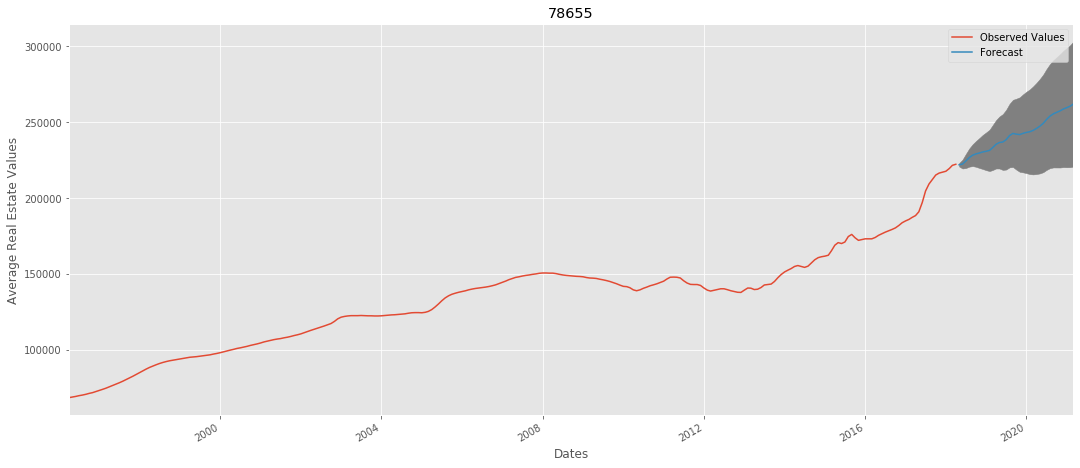

Zipcode : 78655
City :  Martindale
State :  TX
Investment($) : 222300
********
Predicted price in 3 years : 263136.0
Total Increase in 3 years : 40836.399967126374
Increase rate in 3 years (%) : 0.18
Possible range : 221084.0  -  305189.0
********
Predicted price in 5 years : 302750.0
Total Increase in 5 years : 80450.17071661464
Increase rate in 5 years (%) : 0.36
Possible range : 232197.0  -  373303.0
-----------------------------------------------------------------------------


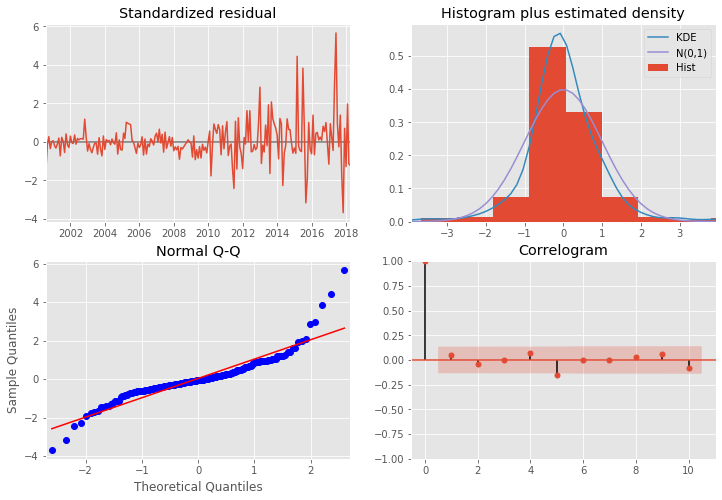

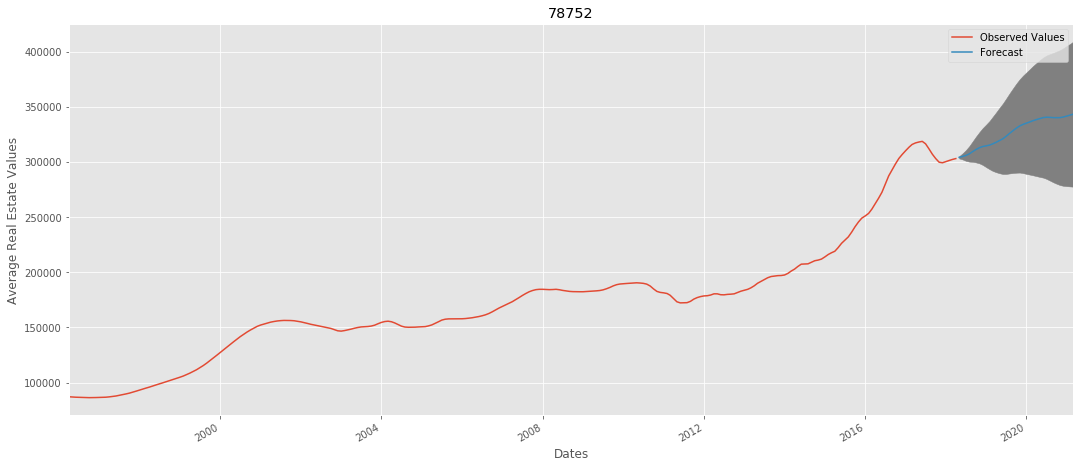

Zipcode : 78752
City :  Austin
State :  TX
Investment($) : 303100
********
Predicted price in 3 years : 344202.0
Total Increase in 3 years : 41101.91920394637
Increase rate in 3 years (%) : 0.14
Possible range : 277373.0  -  411031.0
********
Predicted price in 5 years : 365730.0
Total Increase in 5 years : 62630.009648325795
Increase rate in 5 years (%) : 0.21
Possible range : 270887.0  -  460573.0
-----------------------------------------------------------------------------


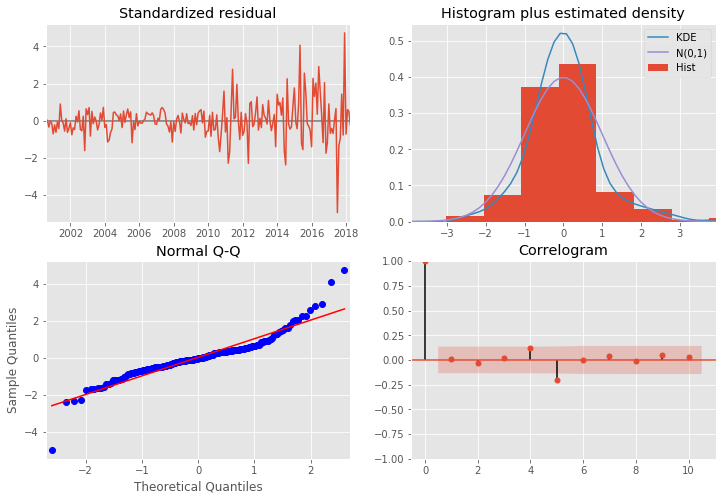

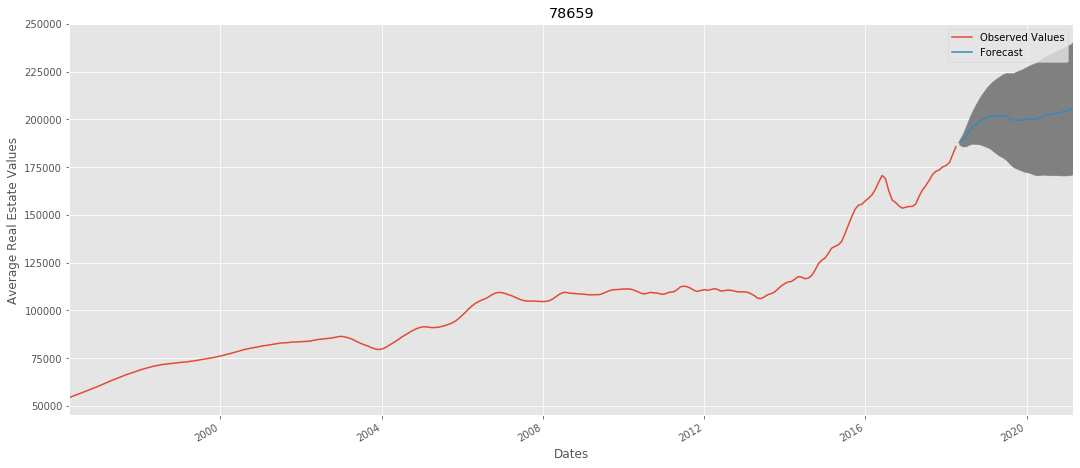

Zipcode : 78659
City :  Paige
State :  TX
Investment($) : 185700
********
Predicted price in 3 years : 207203.0
Total Increase in 3 years : 21503.445217908156
Increase rate in 3 years (%) : 0.12
Possible range : 172154.0  -  242253.0
********
Predicted price in 5 years : 220083.0
Total Increase in 5 years : 34383.12656162522
Increase rate in 5 years (%) : 0.19
Possible range : 173492.0  -  266674.0
-----------------------------------------------------------------------------


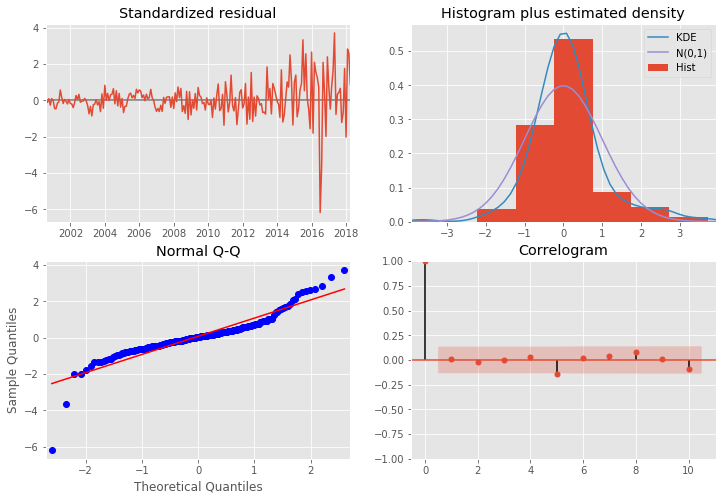

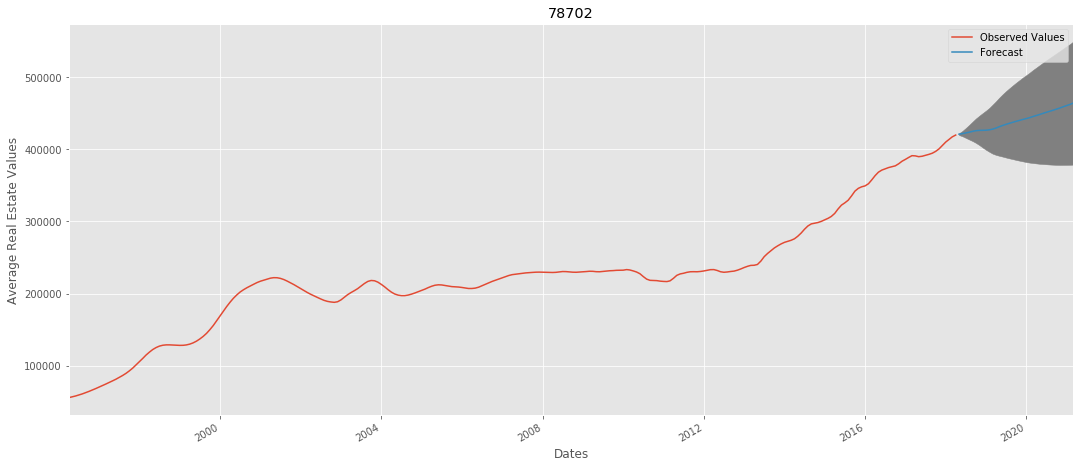

Zipcode : 78702
City :  Austin
State :  TX
Investment($) : 419800
********
Predicted price in 3 years : 465739.0
Total Increase in 3 years : 45939.44208856288
Increase rate in 3 years (%) : 0.11
Possible range : 378902.0  -  552577.0
********
Predicted price in 5 years : 500701.0
Total Increase in 5 years : 80901.41068622377
Increase rate in 5 years (%) : 0.19
Possible range : 376497.0  -  624906.0
-----------------------------------------------------------------------------


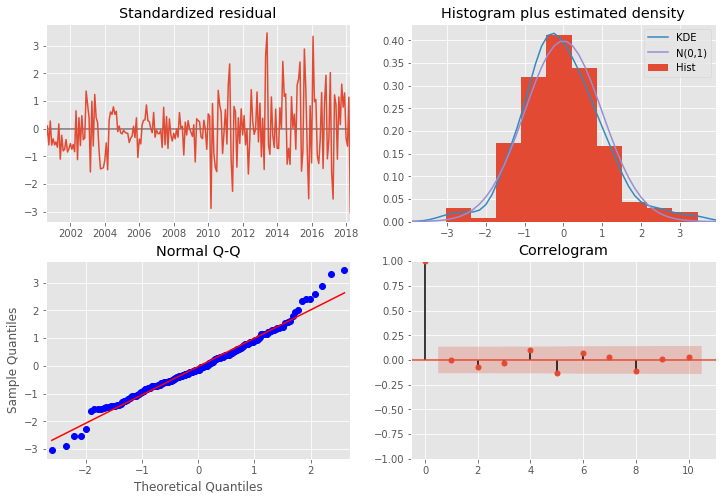

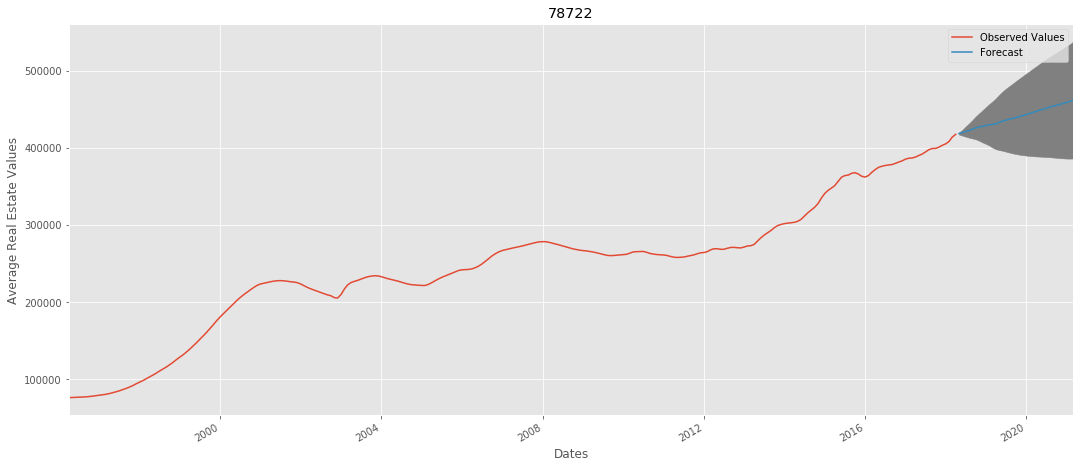

Zipcode : 78722
City :  Austin
State :  TX
Investment($) : 417500
********
Predicted price in 3 years : 463557.0
Total Increase in 3 years : 46057.336140948406
Increase rate in 3 years (%) : 0.11
Possible range : 386359.0  -  540756.0
********
Predicted price in 5 years : 493872.0
Total Increase in 5 years : 76371.5119353719
Increase rate in 5 years (%) : 0.18
Possible range : 382721.0  -  605022.0
-----------------------------------------------------------------------------


"output=arima(df_state_top10[78702], pdq_new, pdqs_new)\nprediction , pred_conf= forecasting (output, 60)\npred_conf['mean']=prediction.predicted_mean\n"

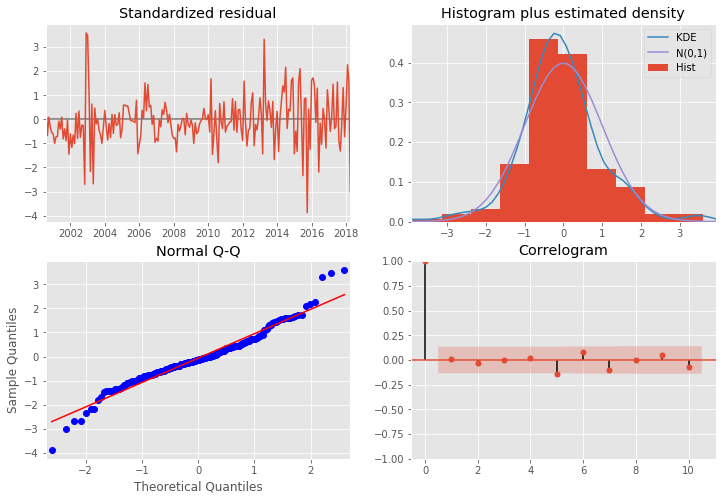

In [359]:
report_plot (zipcodes, combs, ts, df)


#Calculate increase rate in 3 - 5 years
#Plot the forecasted data along with the real data
#prediction_plot(df_state_top10[78702], output)

#### Assumptions for the model have met

From the diognostics plot, we can see if the assumptions met to make sure the model works properly.Residuals resamble white noise and it's KDE has normal distribution with mean 0 and standard deviation of 1.Also,  the qq-plot shows that the ordered distribution of residuals mostly follows the linear trend of the samples taken from a standard normal distribution These indicate that the residuals are normally distributed. Correlogram shows that the time series residuals have low correlation with lagged versions of itself.

According to the plots above, all columns seem met the assumptions. Although KDE histogram and Q-Q plot indicates some outliers in a few zipcodes, data seem too be ok for this model mostly.  


### Creating Result Tables

In [360]:
# Add City, 
report=pred_data.iloc[:5,:]
city=[]
state=[]
metro=[]
for i in zipcodes:
    city.append(df[df.RegionName==i].City.to_string(index=False))
    state.append(df[df.RegionName==i].State.to_string(index=False))  
    metro.append(df[df.RegionName==i].Metro.to_string(index=False))  
report['State'] = state
report['City'] = city
report['Metro'] = metro

report_3_yrs= report[['Zipcode',"City", "State","Metro", 'Investment', 'forecast_3_years', "rate_3", 
                      "3_year_min", "3_year_max", "risk_range_3"]]
report_5_yrs= report[['Zipcode',"City", "State","Metro", 'Investment', 'forecast_5_years', "rate_5", 
                      "5_year_min", "5_year_max", "risk_range_5"]]


In [361]:
report_3_yrs.columns=['Zipcode',"City", "State","Metro", 'Investment', 'Price_in_3_yrs', "Growth_Rate", 
                      "Predict_min", "Predict_max", "Risk_Rate"]
report_3_yrs



,Zipcode,City,State,Metro,Investment,Price_in_3_yrs,Growth_Rate,Predict_min,Predict_max,Risk_Rate
8,78655,Martindale,TX,Austin,222300,263136.0,0.18,221084.0,305189.0,0.159815
6,78752,Austin,TX,Austin,303100,344202.0,0.14,277373.0,411031.0,0.194156
7,78659,Paige,TX,Austin,185700,207203.0,0.12,172154.0,242253.0,0.169158
0,78702,Austin,TX,Austin,419800,465739.0,0.11,378902.0,552577.0,0.186452
1,78722,Austin,TX,Austin,417500,463557.0,0.11,386359.0,540756.0,0.166536


In [ ]:
report_5_yrs.columns=['Zipcode',"City", "State", "Metro",'Investment', 'Price_in_5_yrs', "Growth_Rate", 
                      "Predict_min", "Predict_max", "Risk_Rate"]
report_5_yrs



# Step 6: Modelling with Facebook Prophet

In [524]:
#Convert the data the format that fbprophet needs (add ds column with the dates)
ts['ds'] = ts.index
ts


RegionName,78702,78722,78648,78721,78751,78723,78752,78659,78655,78957,ds
1996-04-01,55600,76200,25000,69200,115900,97600,87200,54300,68600,48500,1996-04-01
1996-05-01,56700,76400,25200,68800,116900,99000,87000,55000,69000,48600,1996-05-01
1996-06-01,57900,76500,25500,68400,118000,100300,86800,55700,69400,48800,1996-06-01
1996-07-01,59300,76700,25800,68100,119100,101400,86700,56300,69900,48900,1996-07-01
1996-08-01,60800,77000,26100,67800,120200,101900,86500,57000,70300,49100,1996-08-01
...,...,...,...,...,...,...,...,...,...,...,...
2017-12-01,405200,403300,103000,293000,434500,352500,299300,175100,217100,145400,2017-12-01
2018-01-01,410100,405200,103300,296300,436100,355800,300400,175800,217700,146300,2018-01-01
2018-02-01,413800,408400,104100,297800,437600,358700,301400,177300,219500,148400,2018-02-01
2018-03-01,417300,413900,105900,297200,441200,361900,302300,181400,221600,152400,2018-03-01


In [526]:
from fbprophet import Prophet as proph
def prophet_prediction(df, topzips):
    dscol = [x for x in df.ds]
    
    values = []
    
    for i in topzips:
        ycol = [x for x in df[i]]
        
        ts = pd.DataFrame()
        ts['ds'] = dscol
        ts['y'] = ycol
        
        Model = proph(interval_width=0.95)
        Model.fit(ts)
        
        future_dates = Model.make_future_dataframe(periods=36, freq='MS')
        forecast = Model.predict(future_dates)
        
        forecasted_data=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
        
        increase_3_yrs = round(forecast['yhat'][300] - forecast['yhat'][264], 2)
        increase_rate_3 = round(increase_3_yrs / forecast['yhat'][264], 2)
                                                        
        values.append((i, df[i][-1], increase_3_yrs, increase_rate_3))
        
        
        Model.plot(forecast, uncertainty=True)
        plt.title(i)
        plt.ylabel('Real Estate Value')
        plt.xlabel('Year')
        Model.plot_components(forecast)
        plt.title(i)
        plt.ylabel('Real Estate Value')
        plt.xlabel('Yearly Trend');
        
        
       
        print("Zipcode :" , i)
        print("Investment($) :", df[i][-1] )
        print("********")
        print("Predicted price in 3 years :",round(forecast['yhat'][300] ))
        print('Increase rate in 3 years (%) :',  increase_rate_3 )
        print("-----------------------------------------------------------------------------")    
        
    return values , forecasted_data

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Zipcode : 78655
Investment($) : 222300
********
Predicted price in 3 years : 258029.0
Increase rate in 3 years (%) : 0.21
-----------------------------------------------------------------------------


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Zipcode : 78752
Investment($) : 303100
********
Predicted price in 3 years : 413753.0
Increase rate in 3 years (%) : 0.28
-----------------------------------------------------------------------------


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Zipcode : 78659
Investment($) : 185700
********
Predicted price in 3 years : 227443.0
Increase rate in 3 years (%) : 0.25
-----------------------------------------------------------------------------


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Zipcode : 78702
Investment($) : 419800
********
Predicted price in 3 years : 533840.0
Increase rate in 3 years (%) : 0.26
-----------------------------------------------------------------------------
Zipcode : 78722
Investment($) : 417500
********
Predicted price in 3 years : 502665.0
Increase rate in 3 years (%) : 0.2
-----------------------------------------------------------------------------


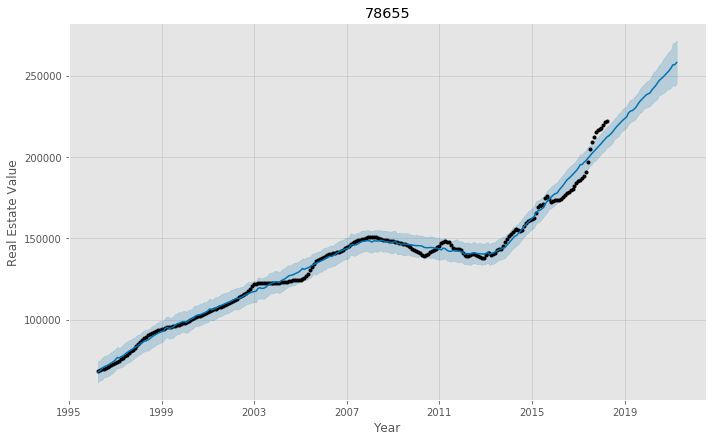

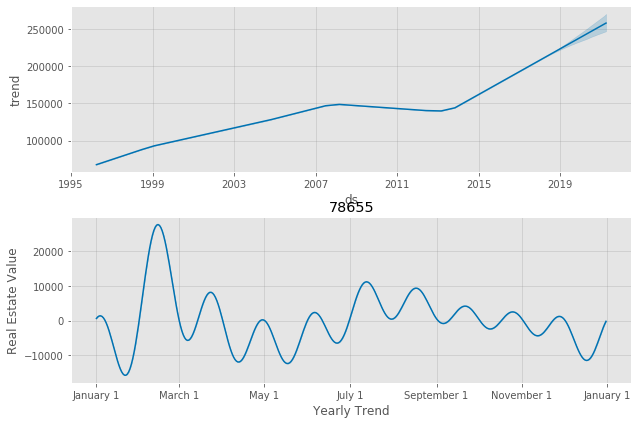

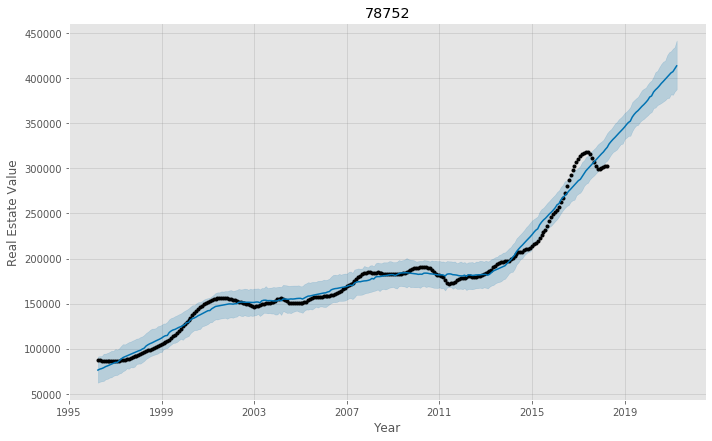

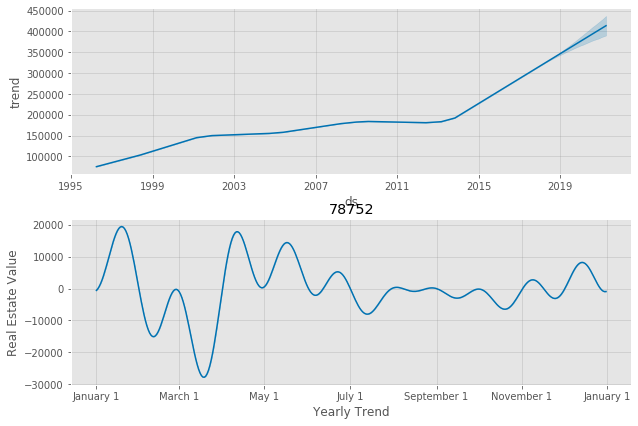

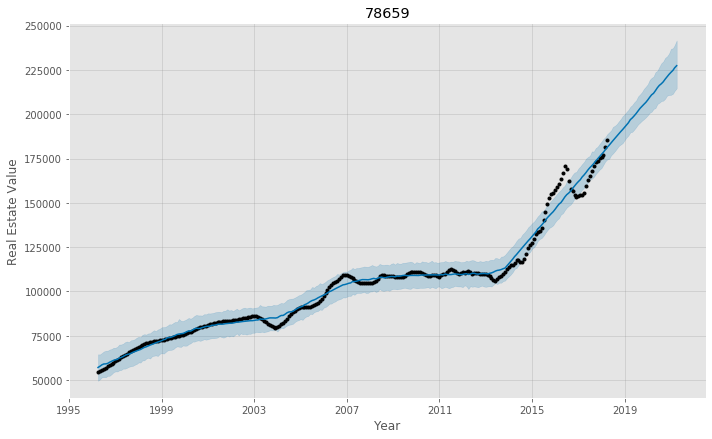

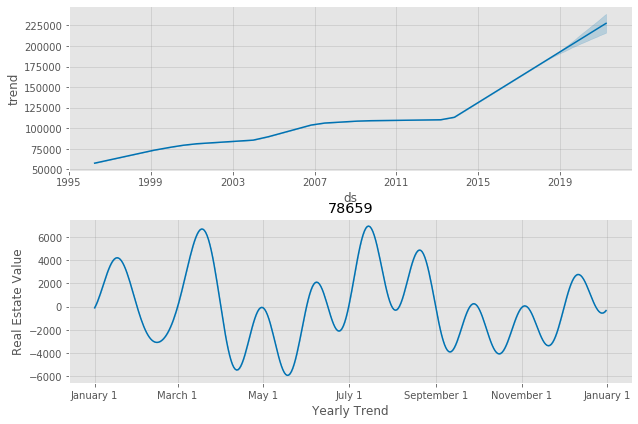

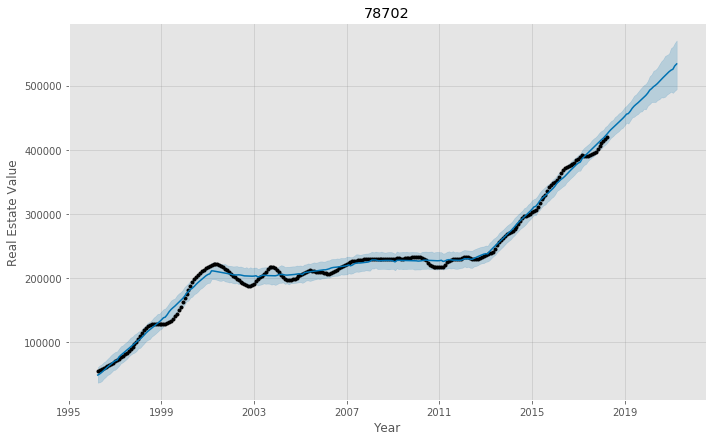

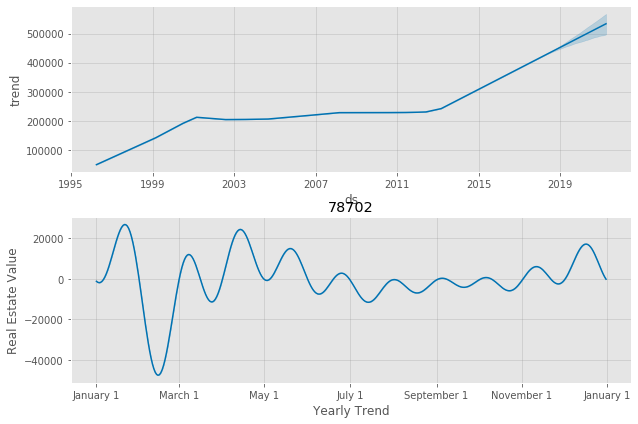

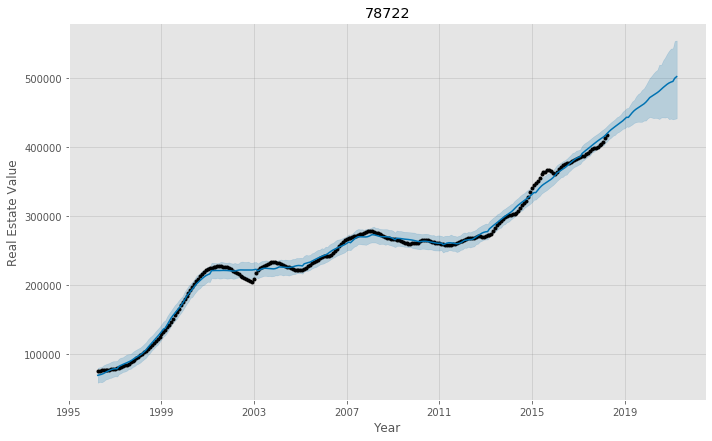

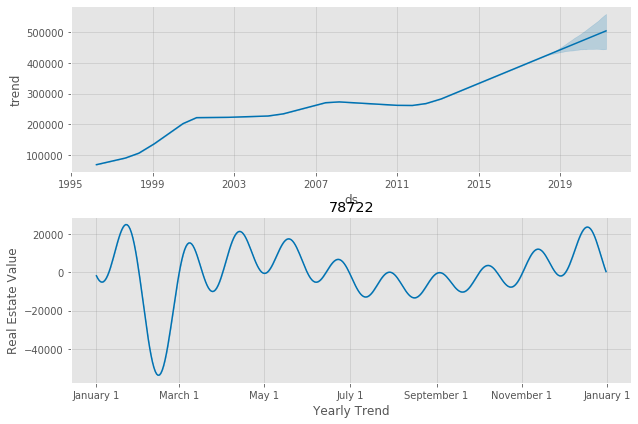

In [527]:
vals, forecasted_data = prophet_prediction(ts, zipcodes)

In [28]:
vals




[(78751, 444500.0, 90710.7, 0.2),
 (78702, 419800.0, 109144.84, 0.26),
 (78722, 417500.0, 82473.51, 0.2),
 (78723, 364200.0, 81169.43, 0.23),
 (78752, 303100.0, 90397.71, 0.28)]

Facebook Prophet Model results are slightly different than SARIMAX model result. Estmations are a little bit higher. 
I would like to test these models performence by running the models with train test split 




# Step 7: Testing the Performence of ARIMA Model

I will visually check the performence of ARIMA forecasting for selected Zipcode. I will use train/test split method to see how accurate the forecasted data will be. I will plot both data on the same axis. 



In [585]:
df_1=ts.iloc[:,:1]
zipcode=[78702]
zipcode

[78702]

In [586]:
smallts=ts[78702].iloc[:80]
#smallts.tail(28)


Zipcode : 78655
Test MSE: 873.008
Standart Deviation: 24109.070227577344
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1905      0.059     20.131      0.000       1.075       1.306
ar.L2         -0.8871      0.084    -10.544      0.000      -1.052      -0.722
ar.L3          0.4852      0.047     10.420      0.000       0.394       0.576
ma.L1          0.2360      0.055      4.273      0.000       0.128       0.344
ar.S.L12      -0.7427      0.128     -5.786      0.000      -0.994      -0.491
ar.S.L24      -0.6858      0.090     -7.642      0.000      -0.862      -0.510
ar.S.L36      -0.4828      0.097     -5.001      0.000      -0.672      -0.294
ma.S.L12      -0.0218      0.108     -0.202      0.840      -0.234       0.190
sigma2      3.183e+05   1.71e+04     18.626      0.000    2.85e+05    3.52e+05


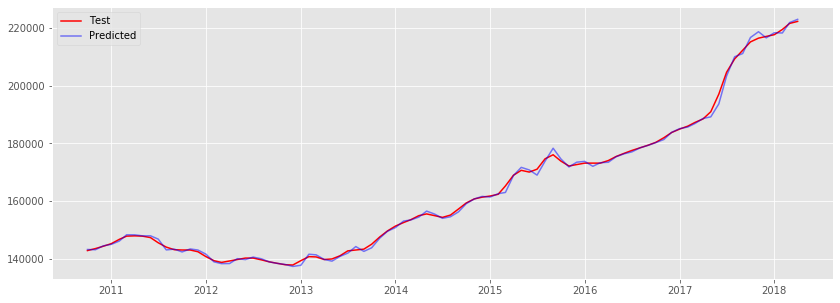

Zipcode : 78752
Test MSE: 778.744
Standart Deviation: 50104.47541595587
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1516      0.111     10.385      0.000       0.934       1.369
ar.L2         -0.4206      0.168     -2.505      0.012      -0.750      -0.091
ar.L3          0.1840      0.083      2.216      0.027       0.021       0.347
ma.L1          0.4633      0.117      3.972      0.000       0.235       0.692
ar.S.L12      -0.2992      0.060     -4.999      0.000      -0.416      -0.182
ar.S.L24      -0.2786      0.100     -2.790      0.005      -0.474      -0.083
ar.S.L36       0.0451      0.027      1.657      0.097      -0.008       0.098
ma.S.L12      -0.9666      0.240     -4.025      0.000      -1.437      -0.496
sigma2      2.461e+05   4.73e+04      5.203      0.000    1.53e+05    3.39e+05


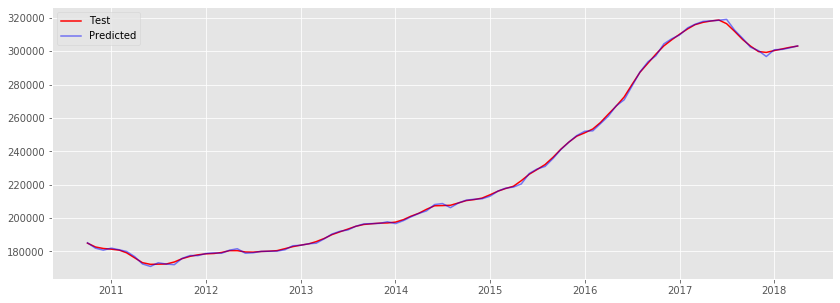

Zipcode : 78659
Test MSE: 1078.015
Standart Deviation: 24887.023460482735
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8969      0.085     10.496      0.000       0.729       1.064
ar.L2         -0.4270      0.116     -3.675      0.000      -0.655      -0.199
ar.L3          0.2706      0.067      4.057      0.000       0.140       0.401
ma.L1          0.5674      0.080      7.055      0.000       0.410       0.725
ar.S.L12      -0.2600      0.065     -4.030      0.000      -0.386      -0.134
ar.S.L24      -0.2173      0.080     -2.731      0.006      -0.373      -0.061
ar.S.L36       0.0494      0.045      1.105      0.269      -0.038       0.137
ma.S.L12      -0.9996      0.057    -17.482      0.000      -1.112      -0.887
sigma2      3.728e+05   1.54e-07   2.43e+12      0.000    3.73e+05    3.73e+05


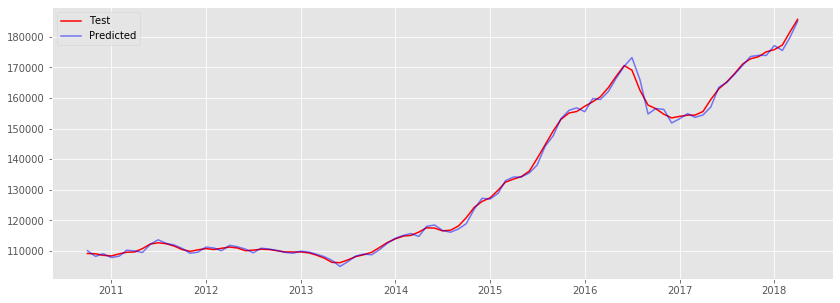

Zipcode : 78702
Test MSE: 890.554
Standart Deviation: 66716.43826589583
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5066      0.075     20.074      0.000       1.360       1.654
ar.L2         -0.9244      0.122     -7.573      0.000      -1.164      -0.685
ar.L3          0.3295      0.075      4.366      0.000       0.182       0.477
ma.L1          0.3340      0.059      5.652      0.000       0.218       0.450
ar.S.L12      -0.7772      0.076    -10.230      0.000      -0.926      -0.628
ar.S.L24      -0.6561      0.080     -8.179      0.000      -0.813      -0.499
ar.S.L36      -0.4639      0.072     -6.435      0.000      -0.605      -0.323
ma.S.L12      -0.1448      0.057     -2.557      0.011      -0.256      -0.034
sigma2      4.592e+05   4.16e+04     11.049      0.000    3.78e+05    5.41e+05


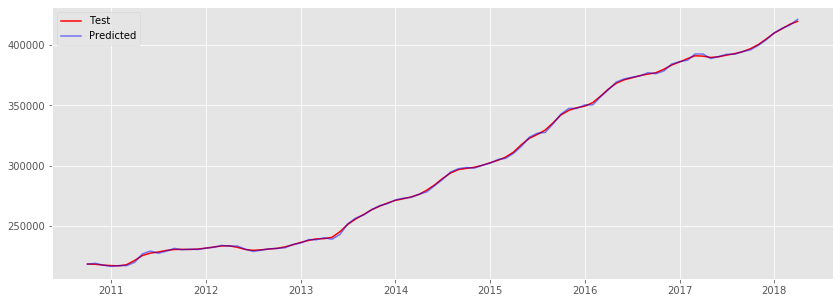

Zipcode : 78722
Test MSE: 834.854
Standart Deviation: 52905.53358238853
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2229      0.075     16.208      0.000       1.075       1.371
ar.L2         -0.6580      0.099     -6.655      0.000      -0.852      -0.464
ar.L3          0.3462      0.053      6.591      0.000       0.243       0.449
ma.L1          0.5119      0.070      7.297      0.000       0.374       0.649
ar.S.L12      -0.3541      0.090     -3.948      0.000      -0.530      -0.178
ar.S.L24      -0.1121      0.066     -1.688      0.091      -0.242       0.018
ar.S.L36       0.0416      0.029      1.455      0.146      -0.014       0.098
ma.S.L12      -0.9982      0.084    -11.939      0.000      -1.162      -0.834
sigma2      4.143e+05   2.06e-07   2.01e+12      0.000    4.14e+05    4.14e+05


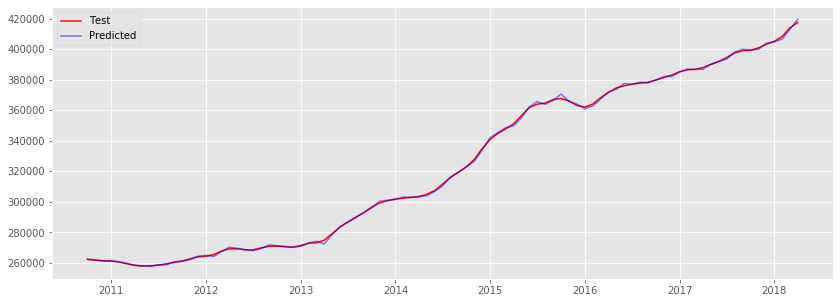

In [591]:
from sklearn.metrics import mean_squared_error
pdq=(3,1,1)
pdqs=(3,1,1,12)


for i in zipcodes:


    X = ts[i]
    size = int(len(X) * 0.66)
    train, test = X[0:size], X[size:len(X)]
    history = [x for x in train]
    predictions = list()


    for t in range(len(test)):
        model = sm.tsa.statespace.SARIMAX(history,
                                        order=pdq_new,
                                        seasonal_order=pdqs_new,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        #print('predicted=%f, expected=%f' % (yhat, obs))


    error = np.sqrt(mean_squared_error(test, predictions))
    print("Zipcode :", i )
    print('Test MSE: %.3f' % error)
    print('Standart Deviation:' , np.std(test))
    print(model_fit.summary().tables[1])
    plt.figure(figsize=(14,5))
    #plt.plot(train, label='Train')
    plt.plot(test, color='red', label="Test")
    plt.plot(test.index, predictions, color='blue', label="Predicted", alpha=0.5)
    plt.legend()
    plt.show()  

# Step 8: Conclusion

In [528]:
report_3_yrs

,Zipcode,City,State,Metro,Investment,Price_in_3_yrs,Growth_Rate,Predict_min,Predict_max,Risk_Rate
8,78655,Martindale,TX,Austin,222300,263136.0,0.18,221084.0,305189.0,0.159815
6,78752,Austin,TX,Austin,303100,344202.0,0.14,277373.0,411031.0,0.194156
7,78659,Paige,TX,Austin,185700,207203.0,0.12,172154.0,242253.0,0.169158
0,78702,Austin,TX,Austin,419800,465739.0,0.11,378902.0,552577.0,0.186452
1,78722,Austin,TX,Austin,417500,463557.0,0.11,386359.0,540756.0,0.166536


In [529]:
report_5_yrs

,Zipcode,City,State,Metro,Investment,Price_in_3_yrs,Growth_Rate,Predict_min,Predict_max,Risk_Rate
8,78655,Martindale,TX,Austin,222300,302750.0,0.36,232197.0,373303.0,0.233040
6,78752,Austin,TX,Austin,303100,365730.0,0.21,270887.0,460573.0,0.259325
7,78659,Paige,TX,Austin,185700,220083.0,0.19,173492.0,266674.0,0.211697
0,78702,Austin,TX,Austin,419800,500701.0,0.19,376497.0,624906.0,0.248062
1,78722,Austin,TX,Austin,417500,493872.0,0.18,382721.0,605022.0,0.225058


 
 
  - The best zipcodes to invest in Texas are 78655, 78752, 78659, 78702, 78722
  - The best range for investment is 100K-500K in  terms of the rate of price increase
  - Austin Metro Area has the fastest growing real estate market in Texas
  - Beacuse of the numerous hight tech companies openning branches in Austin last 10 years, the increasing trend is expected to be long term. So, the longer investment horizon could be rewarding, despite the increased risk on the model's forecast.


# Future Work


- Among all states New York has the best average on Real Estate price, the model can be run for NYC to suggest 5 best zipcodes in NY
- 